In [27]:
import base, numpy as np, matplotlib.pyplot as plt
from base import rbfprojector, DDPG, Memory, Cheetah, DQN
from scipy import stats
import matplotlib.pyplot as plt
from time import time
import statistics
import glfw

help(base)

Help on module base:

NAME
    base - ELE2761 Deep Reinforcement Learning helper functinos

DESCRIPTION
    Implements the provided functionality to be used in your solution.
    
    CLASSES
        Model        -- Dynamics model approximator
        Memory       -- Replay Memory
        Pendulum     -- OpenAI Gym Pendulum-v0 environment
    
    FUNCTIONS
        rbfprojector -- Gaussian RBF projector factory

CLASSES
    builtins.object
        Environment
            Cheetah
        Memory
        Network
            DDPG
            DQN
            Model
    
    class Cheetah(Environment)
     |  Creates a new Pendulum environment.
     |  
     |  Method resolution order:
     |      Cheetah
     |      Environment
     |      builtins.object
     |  
     |  Methods defined here:
     |  
     |  __init__(self)
     |      Creates a new Pendulum environment.
     |      
     |      EXAMPLE
     |          >>> env = Pendulum()
     |          >>> print(env.states)
     |       

# DDPG

In [5]:
env = Cheetah()

In [17]:
rodadas = 3
train_episodes = 500
test_episodes = 100

runs_total_reward = []
runs_computation_time = []
runs_end_performance = []

full_start_time = time()

for rodada in range(rodadas):
    

    K = 1 # rollout
    lista_rewards = np.empty(train_episodes)

    camadas = [400,300]

    #17 elementos em cada estado
    #6 ações ao mesmo tempo entre -1 e +1
    # DDPG
    ddpg = DDPG(17,6,camadas)
    # target DDPG
    t_ddpg = DDPG(17,6,camadas)
    # Create replay memory
    memory = Memory(17,6)

    # Parameters
    gamma = 0.99
    sigma = 0.8
    batch_size = 256
    target_delay = 800
    
    
    training_start_time = time()    
    
    print('----------------------------Episodes start----------------------------')
    for e in range(train_episodes):
        # reset total reward
        total_reward = 0

        # Reset environment
        s = env.reset()

        #----------------------------Time Steps start----------------------------
        for t in range(2000):
            # valor do estado dada uma ação (ação padrão é ação do actor)
            Q = ddpg.critic(s)

            # Select action ( sample a from policy(s,actor) + Noise )
            a = np.random.normal(ddpg.actor(s), sigma)

            #clip actions in range [-1,1]
            for i in range(6):
                if a[i] < -1:
                    a[i] = -1
                elif a[i] > 1:
                    a[i] = 1

            # Step environment
            s_p, r, done, info = env.step(a)

            # Add transition to replay memory
            memory.add(s, a, r, s_p ,done)

            ########## total reward ########
            total_reward = total_reward + r
            ################################

            #----------------------------Training start----------------------------
            # If at least 2000 transitions in memory, sample minibatch and learn
            if memory.n >= 2000 and t%K == 0:
                for k in range(K):
                    # choose random minibatch
                    b_s, b_a, b_r, b_s_p, b_done = memory.sample(batch_size)


                    #train minibatch
                    Q_sp_ap = t_ddpg.critic(b_s_p)


                    targets = np.empty(batch_size)
                    for i in range(batch_size):
                        if b_done[i]:
                            targets[i] = b_r[i]
                        else:
                             targets[i] = b_r[i] + gamma * Q_sp_ap[i]

                    ddpg.train(b_s, b_a, targets)
            #----------------------------Training finish----------------------------

            s = np.copy(s_p)

            #Render current state
#             if t%1 == 0:
#                 env.render()

            # Every 200 timesteps, copy weights to target network
            if t%target_delay == 0:
                t_ddpg <<= ddpg 

            if done:
                break

        #----------------------------Time Steps finish----------------------------
        sigma = sigma * 0.98
        if sigma < 0.01:
            sigma = 0.01
        
        
        lista_rewards[e] = total_reward
        print(str(e) + 'Episódio  ——>   total reward: ' + str(total_reward))

        training_end_time = time()
        training_computation_time = training_end_time - training_start_time

    #----------------------------Episodes finish----------------------------

    # TODO: Close environment
    # env.close()
    
    runs_computation_time.append(training_computation_time)
    runs_total_reward.append(lista_rewards)
    print()
    print('Computation time: ' + str(training_computation_time))
    
    #================================ Start Evaluation ================================
    print()
    print('-----------------Iniciating Evaluation-----------------')

    lista_rewards = np.empty(test_episodes)

    #Parameters
    gamma = 0.99
    sigma = 0
    batch_size = 256

    #--------------------------Episodes start---------------------------------
    for e in range(test_episodes):
        total_reward = 0
        
        s = env.reset()
        
        #---------------------Time Step Start----------------------------------
        for t in range(2000):
            Q = ddpg.critic(s)
            
            a = ddpg.actor(s)
            
            s_p, r, done, info = env.step(a)
            
            ########## total reward ########
            total_reward = total_reward + r
            ################################
            
            s = np.copy(s_p)
            
            if done:
                break
        #---------------------Time Step Finish----------------------------------
        lista_rewards[e] = total_reward
        print(str(e) + 'Episódio  ——>   total reward: ' + str(total_reward))
        #--------------------------Episodes finish---------------------------------
    #================================ Finish Evaluation ================================
    runs_end_performance.append(np.mean(lista_rewards))
    print('End performance: ' + str(runs_end_performance[rodada]))
    print()
    print()
        
full_end_time = time()    
full_computation_time = full_end_time - full_start_time
print('Full Computation time: ' + str(full_computation_time))


----------------------------Episodes start----------------------------
0Episódio  ——>   total reward: -397.9790154032034
1Episódio  ——>   total reward: -320.0017192733296
2Episódio  ——>   total reward: -342.72531993951736
3Episódio  ——>   total reward: -312.4279603903616
4Episódio  ——>   total reward: -438.291595810289
5Episódio  ——>   total reward: -303.7181494362885
6Episódio  ——>   total reward: -256.29184373947953
7Episódio  ——>   total reward: -245.67160071673507
8Episódio  ——>   total reward: -403.7035915812724
9Episódio  ——>   total reward: -229.22987124204778
10Episódio  ——>   total reward: -431.9233664695478
11Episódio  ——>   total reward: -341.72542368477207
12Episódio  ——>   total reward: -113.71766184642088
13Episódio  ——>   total reward: -236.20972220602158
14Episódio  ——>   total reward: -382.24878153125303
15Episódio  ——>   total reward: -393.888810396939
16Episódio  ——>   total reward: -232.206406137241
17Episódio  ——>   total reward: -474.034223977111
18Episódio  ——>  

159Episódio  ——>   total reward: 1089.046716611623
160Episódio  ——>   total reward: 1191.571517791708
161Episódio  ——>   total reward: 1470.8183159420078
162Episódio  ——>   total reward: 1436.626233432096
163Episódio  ——>   total reward: 1374.898004255442
164Episódio  ——>   total reward: 1496.6872845004668
165Episódio  ——>   total reward: 1110.4914650509409
166Episódio  ——>   total reward: 1242.944551879875
167Episódio  ——>   total reward: 321.38182721070166
168Episódio  ——>   total reward: 870.47681794812
169Episódio  ——>   total reward: 1550.083130035841
170Episódio  ——>   total reward: 1256.6959809097302
171Episódio  ——>   total reward: 1384.9189944171237
172Episódio  ——>   total reward: 1345.16033845638
173Episódio  ——>   total reward: 1322.1373900138167
174Episódio  ——>   total reward: 1090.2772805970992
175Episódio  ——>   total reward: 835.8995802271246
176Episódio  ——>   total reward: 230.55338929377154
177Episódio  ——>   total reward: 1005.457103924406
178Episódio  ——>   total 

318Episódio  ——>   total reward: 1959.3330926240158
319Episódio  ——>   total reward: 1748.2924375365833
320Episódio  ——>   total reward: 1720.6413337158695
321Episódio  ——>   total reward: 1818.9210547378752
322Episódio  ——>   total reward: 1789.2934294825977
323Episódio  ——>   total reward: 1762.9175495814684
324Episódio  ——>   total reward: 1956.6096436982175
325Episódio  ——>   total reward: 1962.5000253762835
326Episódio  ——>   total reward: 1550.8885770589645
327Episódio  ——>   total reward: 1843.9973502269474
328Episódio  ——>   total reward: -301.9267339458421
329Episódio  ——>   total reward: 1861.6321617823178
330Episódio  ——>   total reward: 1533.1715488516475
331Episódio  ——>   total reward: 1872.6179635579945
332Episódio  ——>   total reward: 2028.8220891783528
333Episódio  ——>   total reward: 1303.1121283384168
334Episódio  ——>   total reward: 1455.4601332371258
335Episódio  ——>   total reward: 1759.9221783821288
336Episódio  ——>   total reward: 1441.9955628319826
337Episódio 

477Episódio  ——>   total reward: 1872.8111107290497
478Episódio  ——>   total reward: 2357.1166607371642
479Episódio  ——>   total reward: 2524.0945656900158
480Episódio  ——>   total reward: 2079.166947779611
481Episódio  ——>   total reward: 1359.0440388568186
482Episódio  ——>   total reward: 2509.147394907111
483Episódio  ——>   total reward: 2316.6512464049706
484Episódio  ——>   total reward: 2241.4114508397342
485Episódio  ——>   total reward: 2212.0867100114538
486Episódio  ——>   total reward: 2343.8783111080165
487Episódio  ——>   total reward: 2043.5150606331524
488Episódio  ——>   total reward: 1943.650098947421
489Episódio  ——>   total reward: 2443.0217279790486
490Episódio  ——>   total reward: 2582.5865667981698
491Episódio  ——>   total reward: 2496.833390268013
492Episódio  ——>   total reward: 2304.1365408501215
493Episódio  ——>   total reward: 2365.5732870052598
494Episódio  ——>   total reward: 2113.325716541822
495Episódio  ——>   total reward: 2062.0031623900854
496Episódio  ——> 

35Episódio  ——>   total reward: -573.7528635435103
36Episódio  ——>   total reward: -565.2267252265069
37Episódio  ——>   total reward: 225.85541664296503
38Episódio  ——>   total reward: -360.37831688890185
39Episódio  ——>   total reward: -438.11563879197854
40Episódio  ——>   total reward: -142.41783164523488
41Episódio  ——>   total reward: -299.0300067752356
42Episódio  ——>   total reward: -466.1695417833254
43Episódio  ——>   total reward: -380.8173009634268
44Episódio  ——>   total reward: -391.43870547264174
45Episódio  ——>   total reward: -137.9282859308389
46Episódio  ——>   total reward: -341.85739829143324
47Episódio  ——>   total reward: -554.3685233810631
48Episódio  ——>   total reward: -383.849168913524
49Episódio  ——>   total reward: -487.0312910833765
50Episódio  ——>   total reward: -399.98381113244335
51Episódio  ——>   total reward: -551.8112925939848
52Episódio  ——>   total reward: -371.68633807633586
53Episódio  ——>   total reward: -523.0754981992542
54Episódio  ——>   total r

195Episódio  ——>   total reward: 1019.1525866272324
196Episódio  ——>   total reward: 1327.2701722046577
197Episódio  ——>   total reward: 1431.131301870258
198Episódio  ——>   total reward: 1413.6014802708933
199Episódio  ——>   total reward: 989.3314760908358
200Episódio  ——>   total reward: 365.72610466577146
201Episódio  ——>   total reward: 303.89392113344906
202Episódio  ——>   total reward: 340.08905427846537
203Episódio  ——>   total reward: -96.39725480000652
204Episódio  ——>   total reward: 427.4764117026715
205Episódio  ——>   total reward: 281.7383183075266
206Episódio  ——>   total reward: 538.5081175703755
207Episódio  ——>   total reward: 1242.366525106562
208Episódio  ——>   total reward: 980.5030060034496
209Episódio  ——>   total reward: 465.3631640367717
210Episódio  ——>   total reward: 1484.9460112419426
211Episódio  ——>   total reward: 1020.0004229157403
212Episódio  ——>   total reward: 881.6460674838416
213Episódio  ——>   total reward: 1500.9570514050474
214Episódio  ——>   to

354Episódio  ——>   total reward: 1838.2022599952493
355Episódio  ——>   total reward: 2243.860596567088
356Episódio  ——>   total reward: 1841.4853649833474
357Episódio  ——>   total reward: 1763.8609200875972
358Episódio  ——>   total reward: 2007.3658167110495
359Episódio  ——>   total reward: 1951.582148905571
360Episódio  ——>   total reward: 2669.3658336409776
361Episódio  ——>   total reward: 780.0831276303147
362Episódio  ——>   total reward: 2196.728626571258
363Episódio  ——>   total reward: 954.1089635035692
364Episódio  ——>   total reward: 1736.6564525043464
365Episódio  ——>   total reward: 2294.6287337261483
366Episódio  ——>   total reward: 1823.0229532952599
367Episódio  ——>   total reward: 2479.4330251430542
368Episódio  ——>   total reward: 691.5831059817596
369Episódio  ——>   total reward: 2096.217372104053
370Episódio  ——>   total reward: 2384.94658018864
371Episódio  ——>   total reward: 2311.1208613102153
372Episódio  ——>   total reward: 1942.5299088504048
373Episódio  ——>   to

12Episódio  ——>   total reward: 1794.387857482653
13Episódio  ——>   total reward: 1437.0810954879419
14Episódio  ——>   total reward: 1166.5972485277823
15Episódio  ——>   total reward: 2449.5067959229077
16Episódio  ——>   total reward: 2507.6089873599994
17Episódio  ——>   total reward: 1643.5041909995507
18Episódio  ——>   total reward: 2518.364927479006
19Episódio  ——>   total reward: 2700.264726094964
20Episódio  ——>   total reward: 2703.7363111730638
21Episódio  ——>   total reward: 2569.282259804775
22Episódio  ——>   total reward: 2531.3609656190715
23Episódio  ——>   total reward: 2592.4244640837087
24Episódio  ——>   total reward: 2673.9685863257173
25Episódio  ——>   total reward: 1592.8320975912627
26Episódio  ——>   total reward: 2532.9169529142605
27Episódio  ——>   total reward: 2284.9012333911205
28Episódio  ——>   total reward: 1533.7050942889334
29Episódio  ——>   total reward: 1210.8308381820782
30Episódio  ——>   total reward: 2318.4666833324527
31Episódio  ——>   total reward: 725

71Episódio  ——>   total reward: -557.6014971308941
72Episódio  ——>   total reward: -473.29439469245875
73Episódio  ——>   total reward: -327.0104504451337
74Episódio  ——>   total reward: -796.2536809876932
75Episódio  ——>   total reward: -363.31669118129616
76Episódio  ——>   total reward: -311.72819084052395
77Episódio  ——>   total reward: -132.36187391710013
78Episódio  ——>   total reward: -75.2830195446713
79Episódio  ——>   total reward: -604.590991419973
80Episódio  ——>   total reward: -587.6364800671748
81Episódio  ——>   total reward: -518.537815917385
82Episódio  ——>   total reward: -499.6180362906446
83Episódio  ——>   total reward: 122.958796631344
84Episódio  ——>   total reward: 51.57060714504513
85Episódio  ——>   total reward: -306.6291267438236
86Episódio  ——>   total reward: 173.13385637029663
87Episódio  ——>   total reward: -365.8664738313449
88Episódio  ——>   total reward: 493.05394024820805
89Episódio  ——>   total reward: 336.12127288750264
90Episódio  ——>   total reward: -

231Episódio  ——>   total reward: 622.9233935499168
232Episódio  ——>   total reward: 1760.6095355463403
233Episódio  ——>   total reward: 2010.5102782387937
234Episódio  ——>   total reward: 2161.0249441219216
235Episódio  ——>   total reward: 1943.0487927529357
236Episódio  ——>   total reward: 1837.780601446587
237Episódio  ——>   total reward: 1815.0532488664642
238Episódio  ——>   total reward: 1896.8998811463953
239Episódio  ——>   total reward: 601.3685881637043
240Episódio  ——>   total reward: 1861.6642694672328
241Episódio  ——>   total reward: 977.4179937379853
242Episódio  ——>   total reward: 2311.1715198629895
243Episódio  ——>   total reward: 1866.718264497636
244Episódio  ——>   total reward: 1676.0366212769566
245Episódio  ——>   total reward: 2016.477775783272
246Episódio  ——>   total reward: 2008.6176962094012
247Episódio  ——>   total reward: 2122.5796771263936
248Episódio  ——>   total reward: 1200.579837383227
249Episódio  ——>   total reward: 1534.1522428548765
250Episódio  ——>   

390Episódio  ——>   total reward: 2091.4615026400493
391Episódio  ——>   total reward: 2628.1542409544277
392Episódio  ——>   total reward: 2753.8256426678713
393Episódio  ——>   total reward: 2907.2833409476743
394Episódio  ——>   total reward: 2267.644130859847
395Episódio  ——>   total reward: 2617.867132238611
396Episódio  ——>   total reward: 3044.1876359999087
397Episódio  ——>   total reward: 1900.6252711388706
398Episódio  ——>   total reward: 2698.4355273552937
399Episódio  ——>   total reward: 2565.048780656194
400Episódio  ——>   total reward: 2804.366689274014
401Episódio  ——>   total reward: 3029.4356688685625
402Episódio  ——>   total reward: 1493.827193027367
403Episódio  ——>   total reward: 2408.2913964608515
404Episódio  ——>   total reward: 2596.578978218206
405Episódio  ——>   total reward: -55.8792249977571
406Episódio  ——>   total reward: 3022.085771080077
407Episódio  ——>   total reward: 2883.211275586818
408Episódio  ——>   total reward: 2944.0902336419526
409Episódio  ——>   to

49Episódio  ——>   total reward: 2801.655503391633
50Episódio  ——>   total reward: 2763.6663857560306
51Episódio  ——>   total reward: 2755.2045188582056
52Episódio  ——>   total reward: 2760.371638335687
53Episódio  ——>   total reward: 2467.6069487346717
54Episódio  ——>   total reward: 2664.855858523853
55Episódio  ——>   total reward: 1945.8941568665957
56Episódio  ——>   total reward: 2675.764180433156
57Episódio  ——>   total reward: 2627.924515510849
58Episódio  ——>   total reward: 2385.1183806417835
59Episódio  ——>   total reward: 2663.695659948782
60Episódio  ——>   total reward: 2594.684954235608
61Episódio  ——>   total reward: 2524.3361758915867
62Episódio  ——>   total reward: 2659.4618997766543
63Episódio  ——>   total reward: 2769.0498804919216
64Episódio  ——>   total reward: 2728.975918775412
65Episódio  ——>   total reward: 2588.8494235662515
66Episódio  ——>   total reward: 2461.9079823462007
67Episódio  ——>   total reward: 2762.9110221589985
68Episódio  ——>   total reward: 1720.15

In [18]:
print('Mean End-performance: ' + str(np.mean(runs_end_performance)))
print(np.mean(runs_computation_time))
print(full_computation_time)

Mean End-performance: 2326.318333719508
15053.405969778696
46297.612169504166


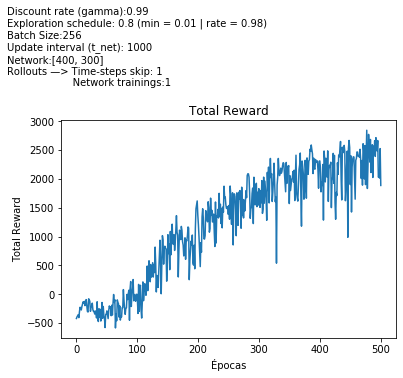

In [19]:
plt.title('Total Reward')
plt.xlabel('Épocas')
plt.ylabel('Total Reward')
plt.figtext(x = 0, y = 1, s = ('Discount rate (gamma):' +  str(gamma) + 
                               '\nExploration schedule: 0.8 (min = 0.01 | rate = 0.98)' +
                               '\nBatch Size:' + str(batch_size) +
                               '\nUpdate interval (t_net): 1000' +
                               '\nNetwork:' + str(camadas) +
                               '\nRollouts —> Time-steps skip: '+ str(K) +
                               '\n                     Network trainings:' + str(K)))

plt.plot(np.linspace(0,train_episodes,train_episodes), np.mean(runs_total_reward, axis = 0))

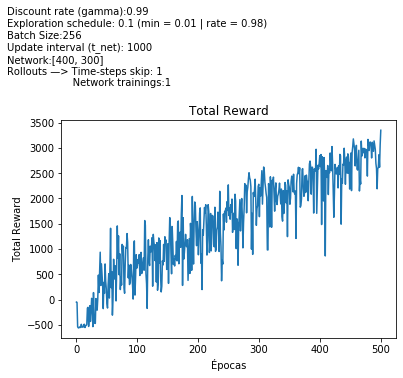

In [16]:
plt.title('Total Reward')
plt.xlabel('Épocas')
plt.ylabel('Total Reward')
plt.figtext(x = 0, y = 1, s = ('Discount rate (gamma):' +  str(gamma) + 
                               '\nExploration schedule: 0.1 (min = 0.01 | rate = 0.98)' +
                               '\nBatch Size:' + str(batch_size) +
                               '\nUpdate interval (t_net): 1000' +
                               '\nNetwork:' + str(camadas) +
                               '\nRollouts —> Time-steps skip: '+ str(K) +
                               '\n                     Network trainings:' + str(K)))

plt.plot(np.linspace(0,train_episodes,train_episodes), np.mean(runs_total_reward, axis = 0))

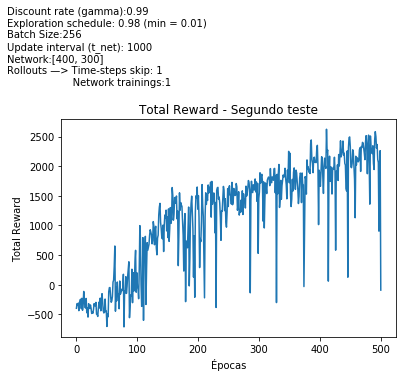

In [24]:
plt.title('Total Reward - Segundo teste')
plt.xlabel('Épocas')
plt.ylabel('Total Reward')
plt.figtext(x = 0, y = 1, s = ('Discount rate (gamma):' +  str(gamma) + 
                               '\nExploration schedule: 0.98 (min = 0.01)' +
                               '\nBatch Size:' + str(batch_size) +
                               '\nUpdate interval (t_net): 1000' +
                               '\nNetwork:' + str(camadas) +
                               '\nRollouts —> Time-steps skip: '+ str(K) +
                               '\n                     Network trainings:' + str(K)))

plt.plot(np.linspace(0,train_episodes,train_episodes), runs_total_reward[0])

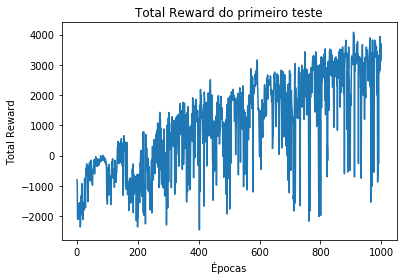

In [4]:
plt.title('Total Reward do primeiro teste')
plt.xlabel('Épocas')
plt.ylabel('Total Reward')
plt.plot(np.linspace(0,episodes,episodes), lista_rewards)
# plt.plot(np.linspace(0,episodes,episodes), np.ones(episodes)*1500)

# Clipped Double Q-learning

In [36]:
rodadas = 3
train_episodes = 500
test_episodes = 100

runs_total_reward = []
runs_computation_time = []
runs_end_performance = []

full_start_time = time()

for rodada in range(rodadas):
    

    K = 1 # rollout
    lista_rewards = np.empty(train_episodes)

    camadas = [400,300]

    #17 elementos em cada estado
    #6 ações ao mesmo tempo entre -1 e +1
    # DDPG
    ddpg = DDPG(17,6,camadas)
    t_ddpg = DDPG(17,6,camadas)
    dqn = DQN(17,6,camadas)
    t_dqn = DQN(17,6,camadas)
    # Create replay memory
    memory = Memory(17,6)

    # Parameters
    gamma = 0.99
    sigma = 0.1
    batch_size = 256
    target_delay = 800
    
    
    training_start_time = time()    
    
    print('----------------------------Episodes start----------------------------')
    for e in range(train_episodes):
        # reset total reward
        total_reward = 0

        # Reset environment
        s = env.reset()

        #----------------------------Time Steps start----------------------------
        for t in range(2000):
            # Select action ( sample a from policy(s,actor) + Noise )
            a = np.random.normal(ddpg.actor(s), sigma)

            #clip actions in range [-1,1]
            for i in range(6):
                if a[i] < -1:
                    a[i] = -1
                elif a[i] > 1:
                    a[i] = 1
            
            Q1 = ddpg.critic(s,a)
            Q2 = dqn(s,a)

            # Step environment
            s_p, r, done, info = env.step(a)

            # Add transition to replay memory
            memory.add(s, a, r, s_p ,done)

            ########## total reward ########
            total_reward = total_reward + r
            ################################

            #----------------------------Training start----------------------------
            # If at least 2000 transitions in memory, sample minibatch and learn
            if memory.n >= 2000 and t%K == 0:
                for k in range(K):
                    # choose random minibatch
                    b_s, b_a, b_r, b_s_p, b_done = memory.sample(batch_size)


                    #train minibatch
                    ap = np.random.normal(ddpg.actor(b_s_p), sigma)
                    Q1_sp_ap = t_ddpg.critic(b_s_p, ap)
                    Q2_sp_ap = t_dqn(b_s_p, ap)


                    targets = np.empty(batch_size)
                    for i in range(batch_size):
                        if b_done[i]:
                            targets[i] = b_r[i]
                        else:
                             targets[i] = b_r[i] + gamma * min(Q1_sp_ap[i], Q2_sp_ap[i])

                    ddpg.train(b_s, b_a, targets)
                    dqn.train(b_s, b_a, targets)
            #----------------------------Training finish----------------------------

            s = np.copy(s_p)

            #Render current state
#             if t%1 == 0:
#                 env.render()

            # Every 200 timesteps, copy weights to target network
            if t%target_delay == 0:
                t_ddpg <<= ddpg 
                t_dqn <<= dqn

            if done:
                break

        #----------------------------Time Steps finish----------------------------
        sigma = sigma * 0.98
        if sigma < 0.01:
            sigma = 0.01
        
        
        lista_rewards[e] = total_reward
        print(str(e) + 'Episódio  ——>   total reward: ' + str(total_reward))

        training_end_time = time()
        training_computation_time = training_end_time - training_start_time

    #----------------------------Episodes finish----------------------------

    # TODO: Close environment
    # env.close()
    
    runs_computation_time.append(training_computation_time)
    runs_total_reward.append(lista_rewards)
    print()
    print('Computation time: ' + str(training_computation_time))
    
    #================================ Start Evaluation ================================
    print()
    print('-----------------Iniciating Evaluation-----------------')

    lista_rewards = np.empty(test_episodes)

    #Parameters
    gamma = 0.99
    sigma = 0
    batch_size = 256

    #--------------------------Episodes start---------------------------------
    for e in range(test_episodes):
        total_reward = 0
        
        s = env.reset()
        
        #---------------------Time Step Start----------------------------------
        for t in range(2000):
            a = ddpg.actor(s)
            
            s_p, r, done, info = env.step(a)
            
            ########## total reward ########
            total_reward = total_reward + r
            ################################
            
            s = np.copy(s_p)
            
            if done:
                break
        #---------------------Time Step Finish----------------------------------
        lista_rewards[e] = total_reward
        print(str(e) + 'Episódio  ——>   total reward: ' + str(total_reward))
        #--------------------------Episodes finish---------------------------------
    #================================ Finish Evaluation ================================
    runs_end_performance.append(np.mean(lista_rewards))
    print('End performance: ' + str(runs_end_performance[rodada]))
    print()
    print()
        
full_end_time = time()    
full_computation_time = full_end_time - full_start_time
print('Full Computation time: ' + str(full_computation_time))


----------------------------Episodes start----------------------------
0Episódio  ——>   total reward: -89.87994316381464
1Episódio  ——>   total reward: -94.9437037052957
2Episódio  ——>   total reward: -542.1915744464409
3Episódio  ——>   total reward: -543.6747870152116
4Episódio  ——>   total reward: -537.6592605964959
5Episódio  ——>   total reward: -561.5051109124619
6Episódio  ——>   total reward: -563.1052810654055
7Episódio  ——>   total reward: -561.891584243378
8Episódio  ——>   total reward: -561.6757632383128
9Episódio  ——>   total reward: -493.1902517670436
10Episódio  ——>   total reward: -416.7987820617807
11Episódio  ——>   total reward: -319.1313260961262
12Episódio  ——>   total reward: -352.1303800809676
13Episódio  ——>   total reward: -202.64469139300158
14Episódio  ——>   total reward: -142.66148850143068
15Episódio  ——>   total reward: -79.8078997829173
16Episódio  ——>   total reward: -22.505757277379093
17Episódio  ——>   total reward: 14.065926649287066
18Episódio  ——>   tot

160Episódio  ——>   total reward: 3780.971911467654
161Episódio  ——>   total reward: 3706.585651971615
162Episódio  ——>   total reward: 3997.716435690752
163Episódio  ——>   total reward: 3999.182462252295
164Episódio  ——>   total reward: 4067.2947582239394
165Episódio  ——>   total reward: 3888.380550355463
166Episódio  ——>   total reward: 3692.940991286102
167Episódio  ——>   total reward: 3934.152744742799
168Episódio  ——>   total reward: 4069.048701708305
169Episódio  ——>   total reward: 4189.173597157853
170Episódio  ——>   total reward: 4134.695609229785
171Episódio  ——>   total reward: 3892.9226007433313
172Episódio  ——>   total reward: 4017.606540655659
173Episódio  ——>   total reward: 4160.711262835727
174Episódio  ——>   total reward: 4415.483624611045
175Episódio  ——>   total reward: 4098.154027373561
176Episódio  ——>   total reward: 4113.195486222127
177Episódio  ——>   total reward: 3704.7163882040736
178Episódio  ——>   total reward: 3838.3509114542285
179Episódio  ——>   total re

321Episódio  ——>   total reward: 4681.517573026247
322Episódio  ——>   total reward: 4561.3327664317185
323Episódio  ——>   total reward: 4740.962563743836
324Episódio  ——>   total reward: 4696.432002258365
325Episódio  ——>   total reward: 4639.251925487858
326Episódio  ——>   total reward: 4656.676818521414
327Episódio  ——>   total reward: 4697.282437299364
328Episódio  ——>   total reward: 4758.298212188908
329Episódio  ——>   total reward: 4526.930152840983
330Episódio  ——>   total reward: 4605.696480052725
331Episódio  ——>   total reward: 4526.198730277475
332Episódio  ——>   total reward: 4632.198492818953
333Episódio  ——>   total reward: 4685.330181530487
334Episódio  ——>   total reward: 4594.342103321148
335Episódio  ——>   total reward: 4805.254036680429
336Episódio  ——>   total reward: 4396.348386108358
337Episódio  ——>   total reward: 4621.422696320798
338Episódio  ——>   total reward: 4562.0166180147335
339Episódio  ——>   total reward: 4475.944539785086
340Episódio  ——>   total rewa

482Episódio  ——>   total reward: 4931.403431297018
483Episódio  ——>   total reward: 5040.245042362081
484Episódio  ——>   total reward: 4685.693321357689
485Episódio  ——>   total reward: 5133.434844004019
486Episódio  ——>   total reward: 4894.2572917432135
487Episódio  ——>   total reward: 5283.415272760081
488Episódio  ——>   total reward: 5059.188665655667
489Episódio  ——>   total reward: 5117.534152554253
490Episódio  ——>   total reward: 4906.193159705692
491Episódio  ——>   total reward: 4757.252915231335
492Episódio  ——>   total reward: 5142.969428210864
493Episódio  ——>   total reward: 5063.616313175848
494Episódio  ——>   total reward: 5113.6490813697255
495Episódio  ——>   total reward: 4880.3113916980865
496Episódio  ——>   total reward: 4994.079908546283
497Episódio  ——>   total reward: 5206.218920728271
498Episódio  ——>   total reward: 5002.715478152599
499Episódio  ——>   total reward: 5159.768579915102

Computation time: 19741.597538471222

-----------------Iniciating Evaluation--

42Episódio  ——>   total reward: 2702.3294406366967
43Episódio  ——>   total reward: 686.4674807272897
44Episódio  ——>   total reward: 261.35485756654384
45Episódio  ——>   total reward: 2055.5852042633805
46Episódio  ——>   total reward: 2521.5550479832514
47Episódio  ——>   total reward: 1739.008371185517
48Episódio  ——>   total reward: 905.9174878531669
49Episódio  ——>   total reward: 895.8135116979581
50Episódio  ——>   total reward: 2133.3976397423335
51Episódio  ——>   total reward: 1746.3937110114327
52Episódio  ——>   total reward: 1469.5377832215438
53Episódio  ——>   total reward: 2772.1418324364213
54Episódio  ——>   total reward: 1899.6374788735184
55Episódio  ——>   total reward: 3128.9935664285863
56Episódio  ——>   total reward: 1174.444847960103
57Episódio  ——>   total reward: 2749.716158203882
58Episódio  ——>   total reward: 1140.1121869197368
59Episódio  ——>   total reward: 3129.592205612809
60Episódio  ——>   total reward: 1730.7063196086403
61Episódio  ——>   total reward: 960.82

204Episódio  ——>   total reward: 4582.364477621178
205Episódio  ——>   total reward: 4710.646611751337
206Episódio  ——>   total reward: 4243.372565788157
207Episódio  ——>   total reward: 4780.357067117546
208Episódio  ——>   total reward: 4328.145279892841
209Episódio  ——>   total reward: 4683.952055181335
210Episódio  ——>   total reward: 4415.972232941027
211Episódio  ——>   total reward: 4526.707148301174
212Episódio  ——>   total reward: 4681.13818191561
213Episódio  ——>   total reward: 4659.049389502754
214Episódio  ——>   total reward: 4524.704867751845
215Episódio  ——>   total reward: 4235.364287228573
216Episódio  ——>   total reward: 4399.427900706155
217Episódio  ——>   total reward: 4521.508014365473
218Episódio  ——>   total reward: 4473.185525228648
219Episódio  ——>   total reward: 4287.059301006084
220Episódio  ——>   total reward: 4366.615501920054
221Episódio  ——>   total reward: 3693.549797882239
222Episódio  ——>   total reward: 4482.220442765086
223Episódio  ——>   total reward:

365Episódio  ——>   total reward: 5073.388340829015
366Episódio  ——>   total reward: 4777.305744478298
367Episódio  ——>   total reward: 5075.254587379955
368Episódio  ——>   total reward: 5072.575831440148
369Episódio  ——>   total reward: 5025.38792809858
370Episódio  ——>   total reward: 5109.90363198083
371Episódio  ——>   total reward: 5020.85560552016
372Episódio  ——>   total reward: 4869.278777190378
373Episódio  ——>   total reward: 4972.448416471321
374Episódio  ——>   total reward: 5077.414299249885
375Episódio  ——>   total reward: 5001.273570113817
376Episódio  ——>   total reward: 4980.401483607064
377Episódio  ——>   total reward: 5134.583581007459
378Episódio  ——>   total reward: 5148.956568309311
379Episódio  ——>   total reward: 5314.361948917645
380Episódio  ——>   total reward: 4777.362377846186
381Episódio  ——>   total reward: 4746.5869215574885
382Episódio  ——>   total reward: 4913.312004424591
383Episódio  ——>   total reward: 5165.440423536194
384Episódio  ——>   total reward: 

25Episódio  ——>   total reward: 5284.273400916024
26Episódio  ——>   total reward: 5224.295709153345
27Episódio  ——>   total reward: 5372.93603700689
28Episódio  ——>   total reward: 5322.4178413303625
29Episódio  ——>   total reward: 5264.480820626497
30Episódio  ——>   total reward: 5279.305072559755
31Episódio  ——>   total reward: 5345.698188970888
32Episódio  ——>   total reward: 5380.92672950633
33Episódio  ——>   total reward: 5202.891660477551
34Episódio  ——>   total reward: 5372.125934167305
35Episódio  ——>   total reward: 5293.60239885457
36Episódio  ——>   total reward: 5259.601065551877
37Episódio  ——>   total reward: 5296.325663088853
38Episódio  ——>   total reward: 5239.461563869684
39Episódio  ——>   total reward: 5260.447439613383
40Episódio  ——>   total reward: 5307.6895633466775
41Episódio  ——>   total reward: 5294.868268122431
42Episódio  ——>   total reward: 5166.643820431452
43Episódio  ——>   total reward: 5241.6569910195985
44Episódio  ——>   total reward: 5320.940565292407


86Episódio  ——>   total reward: 1147.0000613649433
87Episódio  ——>   total reward: 1222.3841347297923
88Episódio  ——>   total reward: 922.5988473359589
89Episódio  ——>   total reward: 1082.0715135190112
90Episódio  ——>   total reward: 1103.953939568983
91Episódio  ——>   total reward: 855.0043777494084
92Episódio  ——>   total reward: 1064.6717548183315
93Episódio  ——>   total reward: 852.9270189088769
94Episódio  ——>   total reward: 1043.0256884752214
95Episódio  ——>   total reward: 1163.5193936149185
96Episódio  ——>   total reward: 1256.3709677931452
97Episódio  ——>   total reward: 1234.867929157697
98Episódio  ——>   total reward: 1041.618059968889
99Episódio  ——>   total reward: 992.9009669713871
100Episódio  ——>   total reward: 1045.6906182634207
101Episódio  ——>   total reward: 948.3524152943547
102Episódio  ——>   total reward: 1075.201658851966
103Episódio  ——>   total reward: 1241.191675606778
104Episódio  ——>   total reward: 1038.951767080276
105Episódio  ——>   total reward: 1174

245Episódio  ——>   total reward: 1186.2152337579246
246Episódio  ——>   total reward: 1165.256712407567
247Episódio  ——>   total reward: 1153.070241530627
248Episódio  ——>   total reward: 1302.018655513098
249Episódio  ——>   total reward: 1360.3780346829585
250Episódio  ——>   total reward: 1327.41951545528
251Episódio  ——>   total reward: 1359.147504120224
252Episódio  ——>   total reward: 1313.8737776273904
253Episódio  ——>   total reward: 1450.1067739471114
254Episódio  ——>   total reward: 1368.8935740103261
255Episódio  ——>   total reward: 1323.4776471583168
256Episódio  ——>   total reward: 1286.945745132731
257Episódio  ——>   total reward: 1289.7141513481693
258Episódio  ——>   total reward: 1387.4267870150088
259Episódio  ——>   total reward: 1346.9867262251928
260Episódio  ——>   total reward: 1290.9228562742178
261Episódio  ——>   total reward: 1300.7292651508478
262Episódio  ——>   total reward: 1354.6730129654636
263Episódio  ——>   total reward: 1102.2925741074891
264Episódio  ——>   

404Episódio  ——>   total reward: 1487.963137963827
405Episódio  ——>   total reward: 1484.0013985352514
406Episódio  ——>   total reward: 1578.3634504574711
407Episódio  ——>   total reward: 1506.1094664117725
408Episódio  ——>   total reward: 1703.1746895917922
409Episódio  ——>   total reward: 1451.8035714793396
410Episódio  ——>   total reward: 1532.667923695679
411Episódio  ——>   total reward: 1529.5354153026274
412Episódio  ——>   total reward: 1609.1373016891584
413Episódio  ——>   total reward: 1507.5352028436812
414Episódio  ——>   total reward: 1506.2833874982261
415Episódio  ——>   total reward: 1518.6320784031961
416Episódio  ——>   total reward: 1507.7790316559042
417Episódio  ——>   total reward: 1566.0552700198011
418Episódio  ——>   total reward: 1669.2556842867953
419Episódio  ——>   total reward: 1476.007875428464
420Episódio  ——>   total reward: 1572.4328374229449
421Episódio  ——>   total reward: 1544.4811796833856
422Episódio  ——>   total reward: 1602.3363165537537
423Episódio  ——

63Episódio  ——>   total reward: 1462.814577195495
64Episódio  ——>   total reward: 1635.575416887939
65Episódio  ——>   total reward: 1541.846707938802
66Episódio  ——>   total reward: 1596.1794554178678
67Episódio  ——>   total reward: 1481.2559251140501
68Episódio  ——>   total reward: 1499.423274398941
69Episódio  ——>   total reward: 1587.0802215360893
70Episódio  ——>   total reward: 1523.6604871763295
71Episódio  ——>   total reward: 1577.1603630441516
72Episódio  ——>   total reward: 1543.6461011968893
73Episódio  ——>   total reward: 1592.9496948000112
74Episódio  ——>   total reward: 1567.1464242400748
75Episódio  ——>   total reward: 1548.3637189730205
76Episódio  ——>   total reward: 1542.5088649125046
77Episódio  ——>   total reward: 1511.3497599155671
78Episódio  ——>   total reward: 1537.771139802591
79Episódio  ——>   total reward: 1580.932275548358
80Episódio  ——>   total reward: 1633.381203778554
81Episódio  ——>   total reward: 1540.1559972082177
82Episódio  ——>   total reward: 1498.9

In [37]:
print('Mean End-performance: ' + str(np.mean(runs_end_performance)))
print(np.mean(runs_computation_time))
print(full_computation_time)

Mean End-performance: 3952.883680127306
21156.408625682194
64392.822944164276


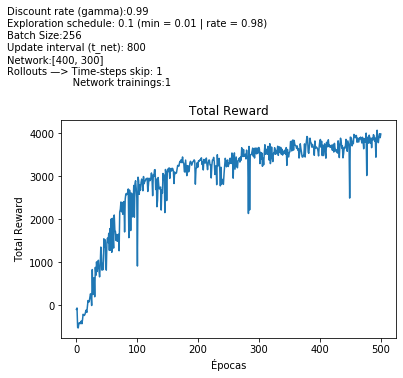

In [40]:
plt.title('Total Reward')
plt.xlabel('Épocas')
plt.ylabel('Total Reward')
plt.figtext(x = 0, y = 1, s = ('Discount rate (gamma):' +  str(gamma) + 
                               '\nExploration schedule: 0.1 (min = 0.01 | rate = 0.98)' +
                               '\nBatch Size:' + str(batch_size) +
                               '\nUpdate interval (t_net): 800' +
                               '\nNetwork:' + str(camadas) +
                               '\nRollouts —> Time-steps skip: '+ str(K) +
                               '\n                     Network trainings:' + str(K)))

plt.plot(np.linspace(0,train_episodes,train_episodes), np.mean(runs_total_reward, axis = 0))

In [34]:
print('Mean End-performance: ' + str(np.mean(runs_end_performance)))
print(np.mean(runs_computation_time))
print(full_computation_time)

Mean End-performance: 2933.0133397334557
20314.74469645818
61323.6025595665


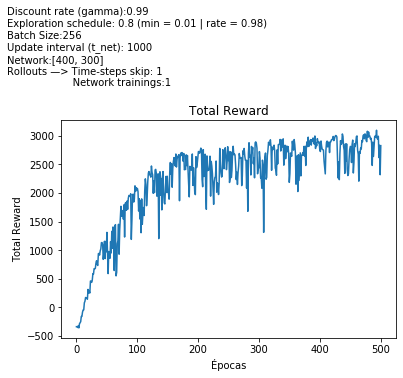

In [35]:
plt.title('Total Reward')
plt.xlabel('Épocas')
plt.ylabel('Total Reward')
plt.figtext(x = 0, y = 1, s = ('Discount rate (gamma):' +  str(gamma) + 
                               '\nExploration schedule: 0.8 (min = 0.01 | rate = 0.98)' +
                               '\nBatch Size:' + str(batch_size) +
                               '\nUpdate interval (t_net): 1000' +
                               '\nNetwork:' + str(camadas) +
                               '\nRollouts —> Time-steps skip: '+ str(K) +
                               '\n                     Network trainings:' + str(K)))

plt.plot(np.linspace(0,train_episodes,train_episodes), np.mean(runs_total_reward, axis = 0))

# Rascunho:

In [16]:
def discretize_actions(actions_high, actions_low, divisions = 3):
    discrete = np.linspace(actions_high, actions_low, divisions)
    return discrete.T
    

In [17]:
high = [1,1,1,1,1,1]
low = [-1,-1,-1,-1,-1,-1]

discretize_actions(high, low)

array([[ 1.,  0., -1.],
       [ 1.,  0., -1.],
       [ 1.,  0., -1.],
       [ 1.,  0., -1.],
       [ 1.,  0., -1.],
       [ 1.,  0., -1.]])

In [18]:
env = Cheetah() 
print(env.states)
print(env.actions)

17
6


In [3]:
import gym

# print(envs.registry.all())

env = gym.make('HalfCheetah-v3')

In [24]:
env.action_space.low, env.action_space.high

array([0., 0., 0., 0., 0., 0.], dtype=float32)

In [6]:
env.action_space.high

array([1., 1., 1., 1., 1., 1.], dtype=float32)

In [27]:
np.linspace(env.action_space.low, env.action_space.high, 5).T

array([[-1. , -0.5,  0. ,  0.5,  1. ],
       [-1. , -0.5,  0. ,  0.5,  1. ],
       [-1. , -0.5,  0. ,  0.5,  1. ],
       [-1. , -0.5,  0. ,  0.5,  1. ],
       [-1. , -0.5,  0. ,  0.5,  1. ],
       [-1. , -0.5,  0. ,  0.5,  1. ]], dtype=float32)

In [25]:
import numpy as np

In [103]:
env = Cheetah()
for i in range(100):
    env.reset()
    env.render()

NameError: name 'Cheetah' is not defined

In [62]:
lista = []
sigma = 1
for i in range(1000):
    lista.append(np.random.normal(10, sigma))

(array([  8.,  32.,  63., 153., 218., 221., 168.,  94.,  28.,   7.]),
 array([ 7. ,  7.6,  8.2,  8.8,  9.4, 10. , 10.6, 11.2, 11.8, 12.4, 13. ]),
 <a list of 10 Patch objects>)

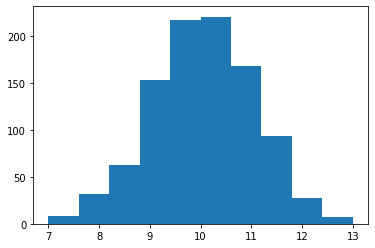

In [63]:
plt.hist(lista, range = (7,13))

In [1]:
import gym
import time
env = gym.make('HalfCheetah-v3')

for i in range(500):
    env.reset()
    env.render()


Creating window glfw


SystemExit: 0

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3339: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [ ]:
env.close()

In [99]:
act = env.action_space.sample()
print(act)

act[5]

[-0.6997205   0.73379105 -0.10480696 -0.13007882  0.04090963 -0.1479336 ]


-0.1479336

In [80]:
def props(cls):
    return [i for i in cls.__dict__.keys() if i[:1] != '_']

properties = props(env.action_space)

In [4]:
a = np.random.normal(ddpg.actor(s), sigma)
a

array([-0.10920153,  0.3572639 , -0.26490524, -0.56425895,  0.33268758,
       -0.40927398])

In [9]:
for i in range(6):
    if a[i] < -1:
        a[i] = -1
    elif a[i] > 1:
        a[i] = 1
            